# OTIS water ice features
We investigate the case of ice contamination during OTIS testing based on MRS data. The dataset used is that of the PAAH ASPA source measurements.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from distortionMaps import d2cMapping
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'OTIS_data/LVL2/'

In [3]:
# load MRS detector images
aspa_sci_imgs,aspa_bkg_imgs,OTIS_intcal_source_sci = {},{},{}
for band in ['1A','1B','1C','2A','2B','2C']:
    aspa_sci_imgs[band],aspa_bkg_imgs[band] = mrsobs.OTIS_ASPA_semiextended_source(lvl2path,band,pointing='v03',output='img')
    OTIS_intcal_source_sci[band] = mrsobs.MIRI_internal_calibration_source(lvl2path+'MRS_RAD_11_CPT/',band,campaign='OTIS')

# load MRS distortion information
lambdaMap,lambdaMap2,xpos,photom_img,pixsiz_img = {},{},{},{},{}
for band in ['1A','1B','1C','2A','2B','2C']:
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    lambdaMap[band] = d2cMaps['lambdaMap']
    ypos,xpos[band] = funcs.detpixel_trace(band,d2cMaps,sliceID=10,alpha_pos=0.)
    photom_img[band] = funcs.get_cdps(band,cdpDir)[1]
    pixsiz_img[band] = funcs.get_cdps(band,cdpDir)[2]

<IPython.core.display.Javascript object>


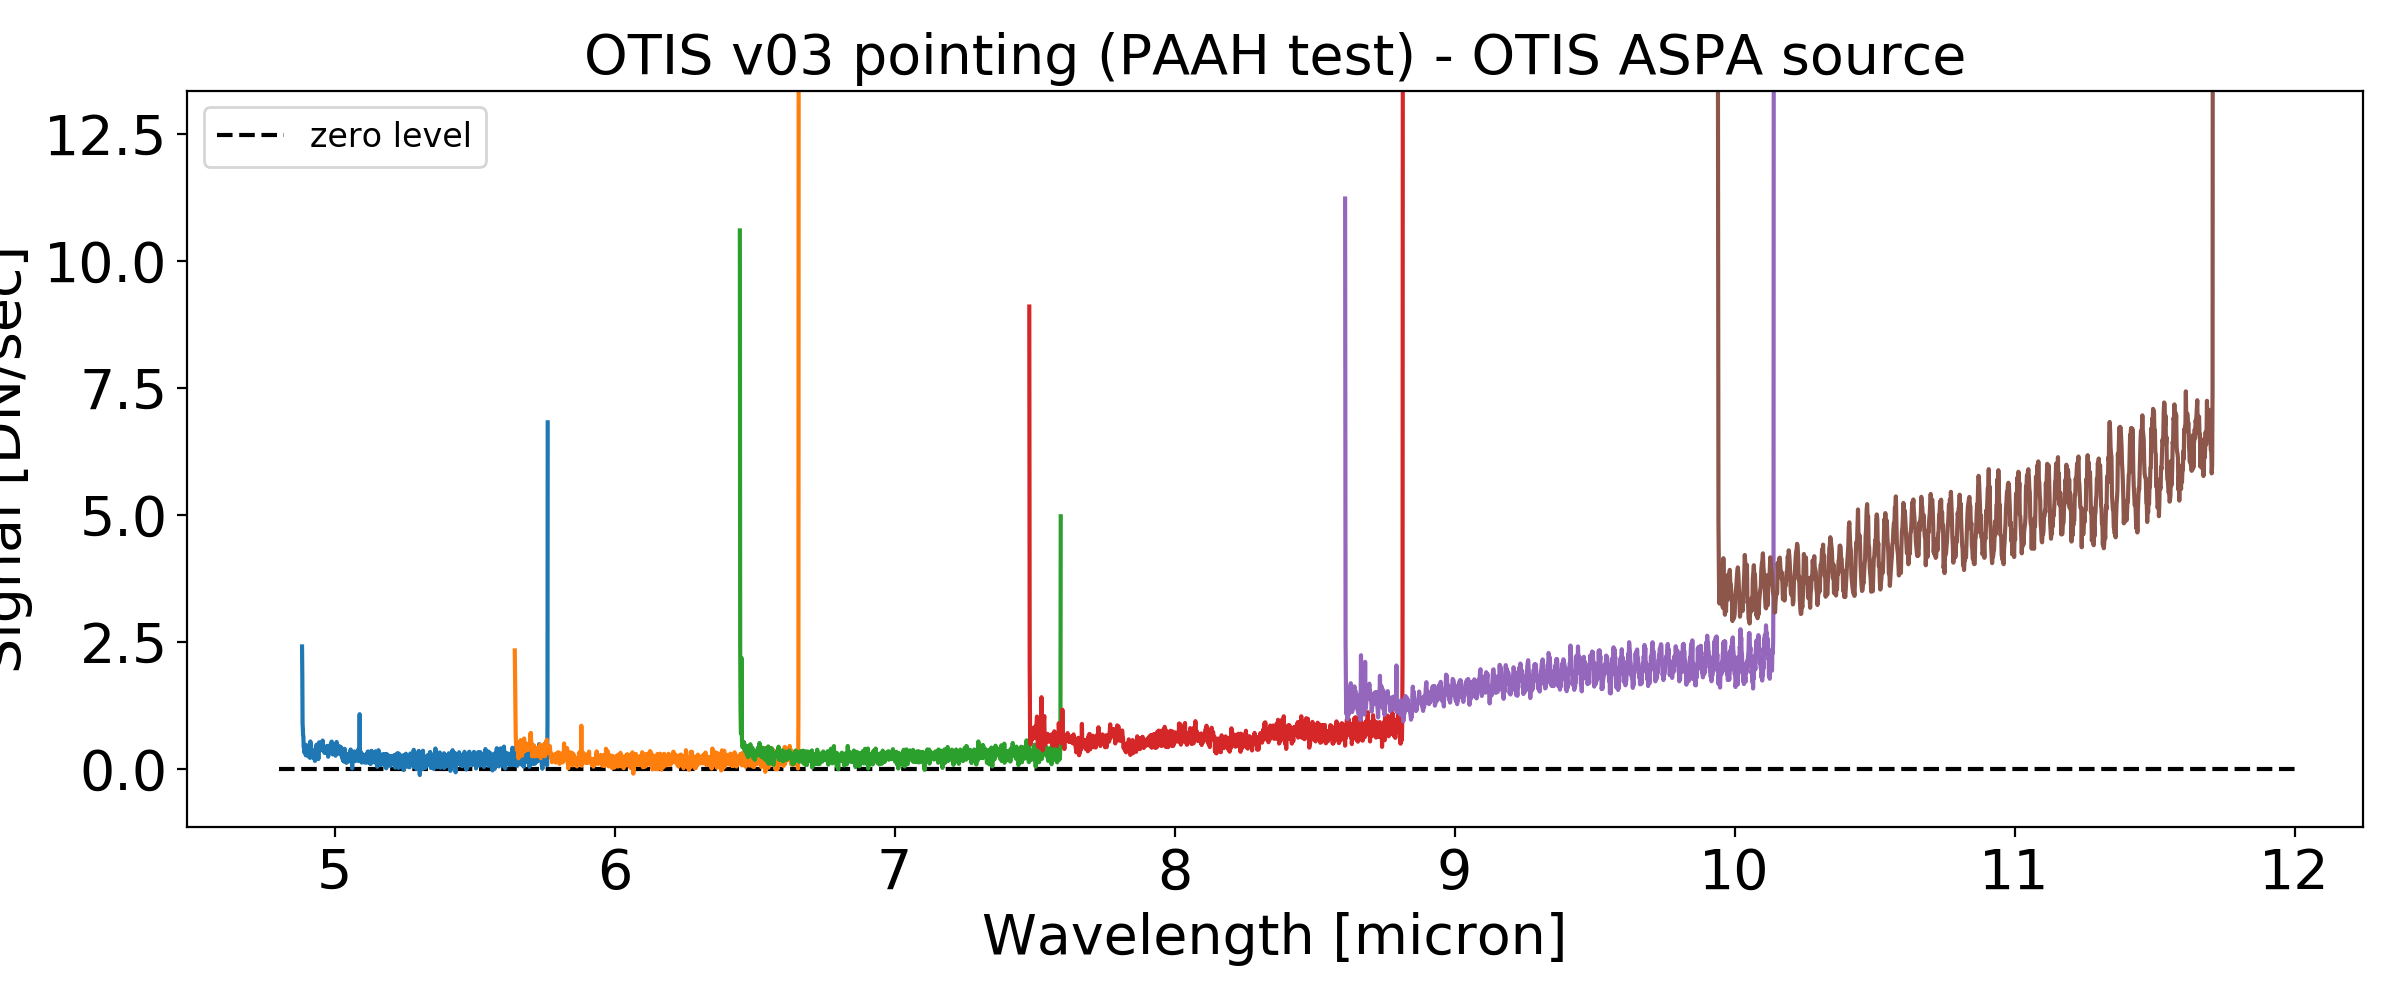

In [4]:
# plot pixel trace
plt.figure(figsize=(12,5))
plt.title('OTIS v03 pointing (PAAH test) - OTIS ASPA source')
for band in ['1A','1B','1C','2A','2B','2C']:
    plt.plot(lambdaMap[band][ypos,xpos[band]],aspa_bkg_imgs[band][ypos,xpos[band]])
plt.hlines(0,4.8,12,linestyle='dashed',label='zero level')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


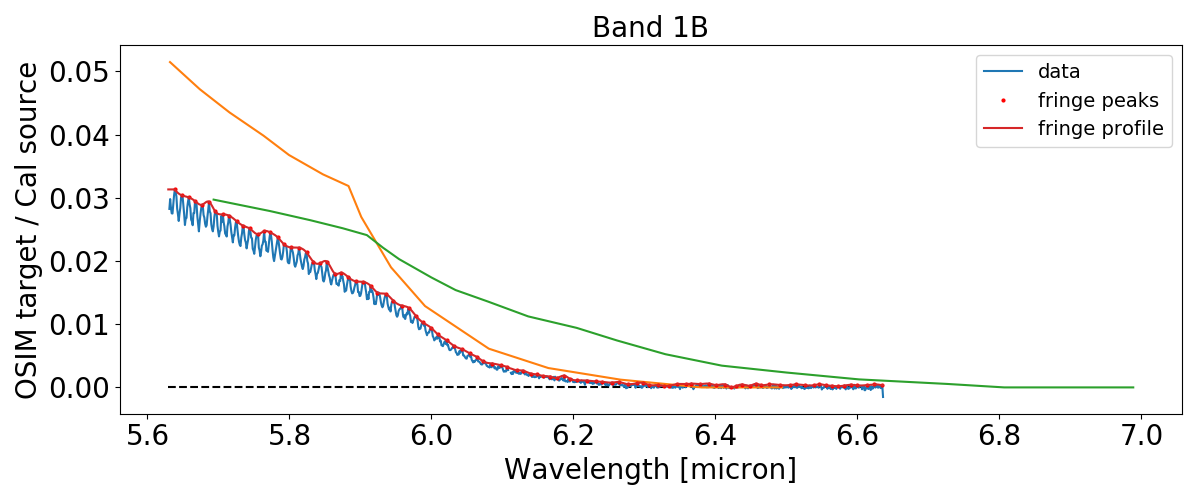

<IPython.core.display.Javascript object>


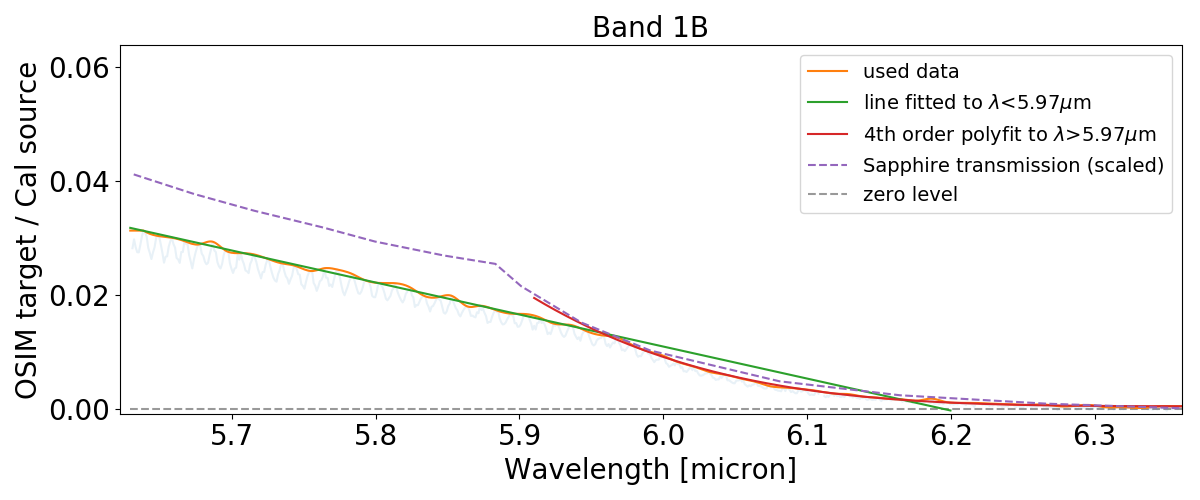

<IPython.core.display.Javascript object>


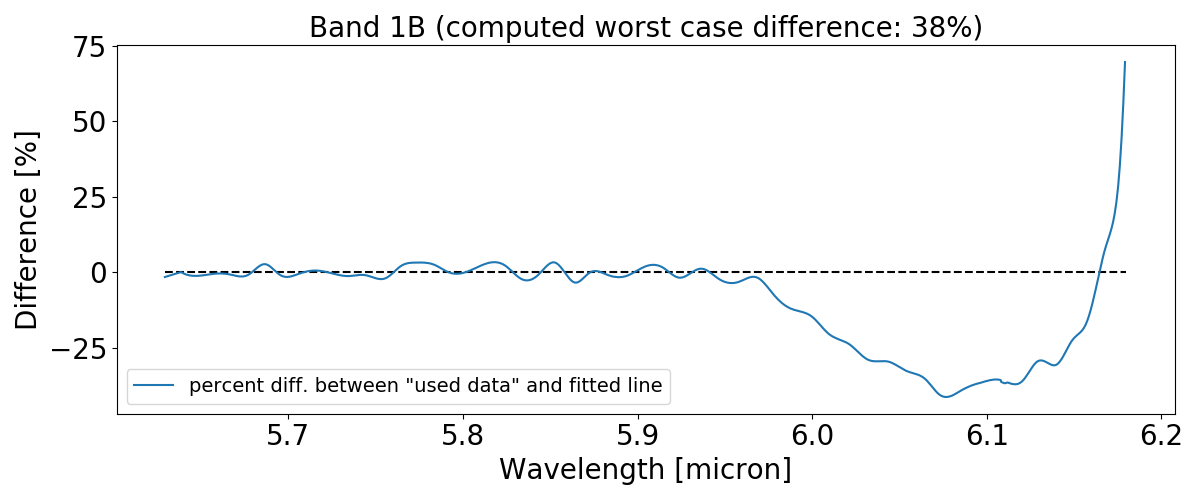

In [8]:
# Examine the OSIM sky flat data in band 1B (wavelength range 5.62-6.73 micron)
band = '1B'
lambdas = lambdaMap2[band][ypos,xpos[band]]
data = ((img_H_1B-img_BKG_1B)/CV2_intcal_source_sci[band])[ypos,xpos[band]]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=7,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(wav_sapph[wav_sapph>lambdas.min()],transm_sapph[wav_sapph>lambdas.min()]/100./4.)
plt.plot(wav_sapph2[wav_sapph2>lambdas.min()],transm_sapph2[wav_sapph2>lambdas.min()]/100./16.)
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

# Investigate regions of interest
sel = (lambdas <5.97)
popt1     = np.polyfit(lambdas[sel],data_profile[sel],1)
poly1     = np.poly1d(popt1)

sel = (lambdas > 5.972)
popt2     = np.polyfit(lambdas[sel],data_profile[sel],4)
poly2     = np.poly1d(popt2)

# plot resulting fits and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas[lambdas<6.2],poly1(lambdas[lambdas<6.2]),label=r'line fitted to $\lambda$<5.97$\mu$m')
plt.plot(lambdas[(lambdas > 5.91)],poly2(lambdas[(lambdas > 5.91)]),label=r'4th order polyfit to $\lambda$>5.97$\mu$m')
plt.plot(wav_sapph[wav_sapph>lambdas.min()],transm_sapph[wav_sapph>lambdas.min()]/100./5.,linestyle='dashed',label='Sapphire transmission (scaled)')
# plt.plot(wav_sapph2[wav_sapph2>lambdas.min()],transm_sapph2[wav_sapph2>lambdas.min()]/100./16.,linestyle='dashed',label='Sapphire transmission (scaled)')
# plt.plot(wav_alon[18:-4],transm_alon[18:-4]/100./8.,'k',linestyle='dashed',label='ALON transmission (scaled)')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed',alpha=0.4,label='zero level')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {} (computed worst case difference: 38%)'.format(band))
plt.plot(lambdas[lambdas<6.18],((data_profile-poly1(lambdas))/poly1(lambdas))[lambdas<6.18]*100.,label='percent diff. between "used data" and fitted line')
plt.hlines(0,lambdas.min(),6.18,linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


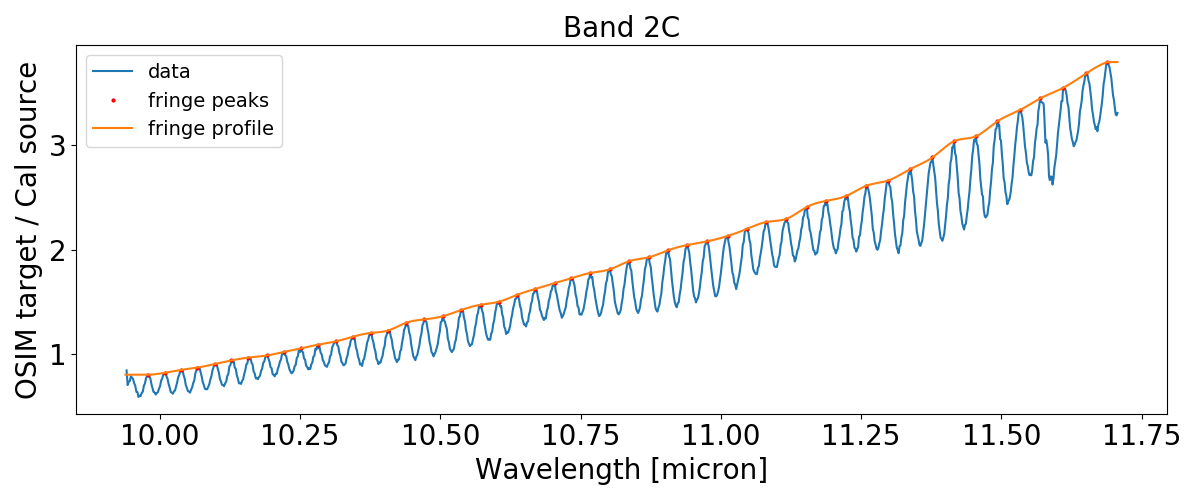

<IPython.core.display.Javascript object>


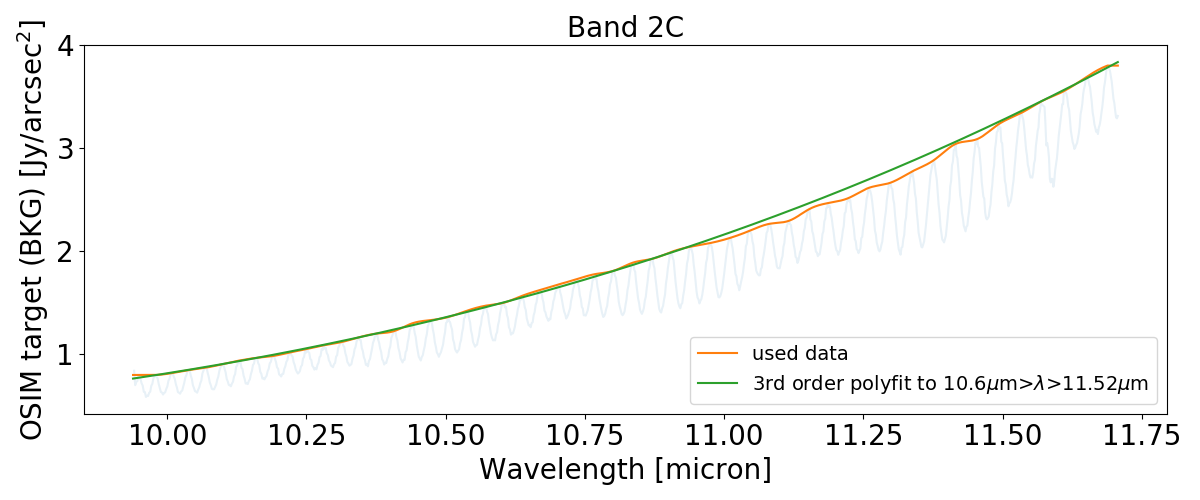

<IPython.core.display.Javascript object>


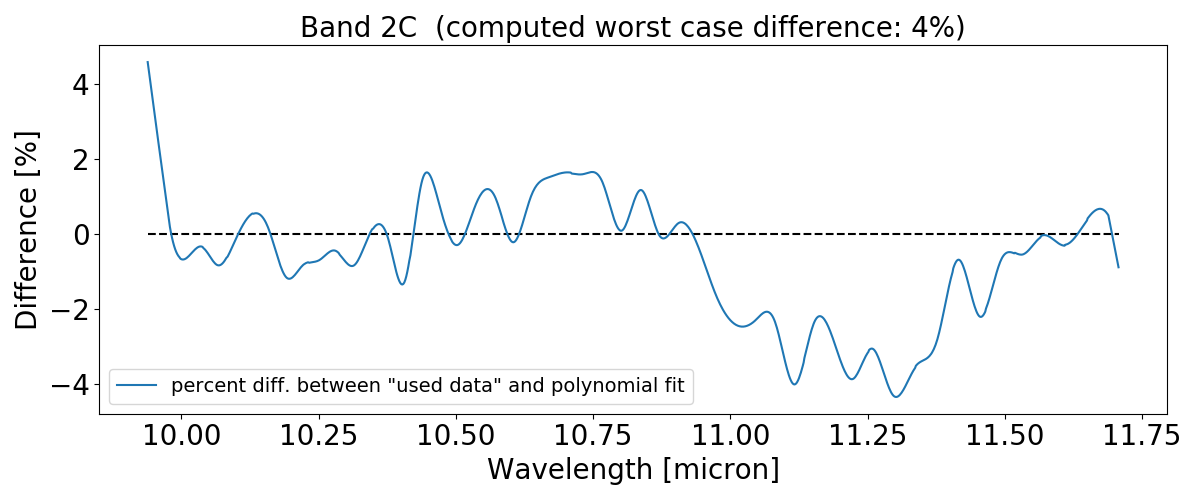

In [31]:
# Examine the OSIM sky flat data in band 2C (wavelength range 9.94-11.87 micron)
band = '2C'
lambdas = lambdaMap[band][ypos,xpos[band]][:-2]
data = (img_H_1C/photom_img[band]/pixsiz_img[band]/1000.)[ypos,xpos[band]][:-2]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=14,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# Investigate region of interest
sel = (lambdas > 10.6) & (lambdas<11.52)
popt1     = np.polyfit(lambdas[~sel],data_profile[~sel],3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to 10.6$\mu$m>$\lambda$>11.52$\mu$m')
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'OSIM target (BKG) [Jy/arcsec$^2$]')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}  (computed worst case difference: 4%)'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


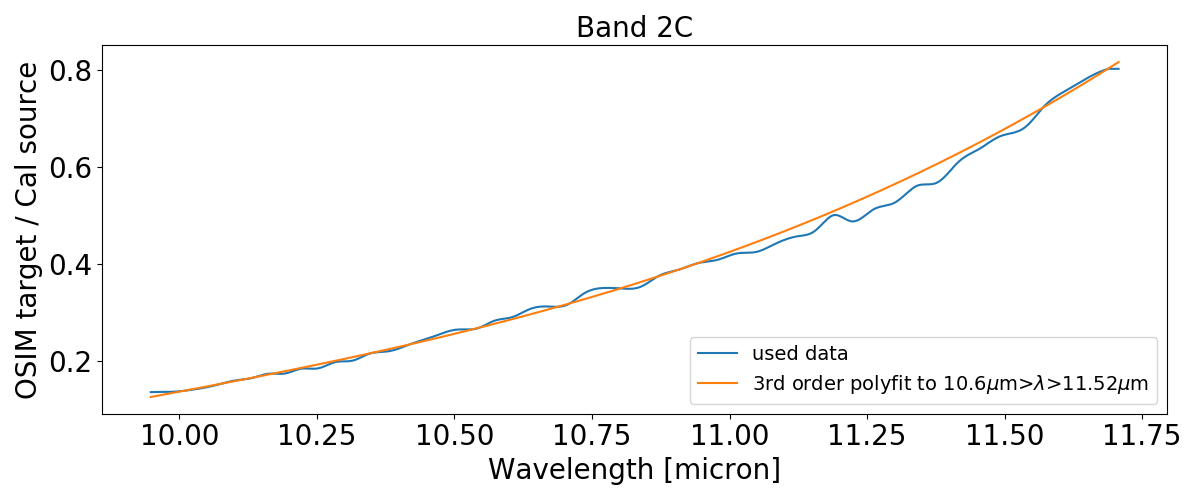

<IPython.core.display.Javascript object>


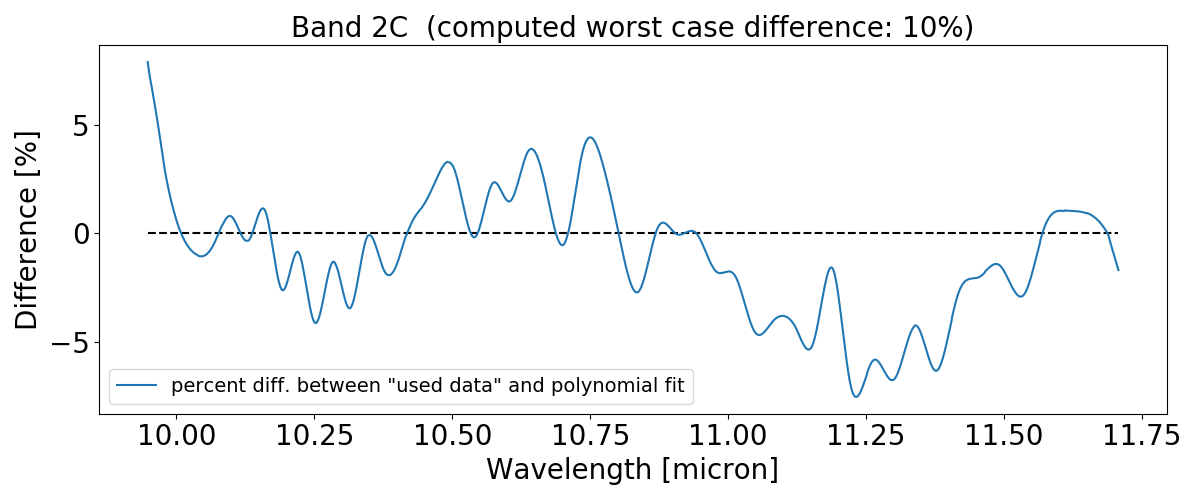

<IPython.core.display.Javascript object>


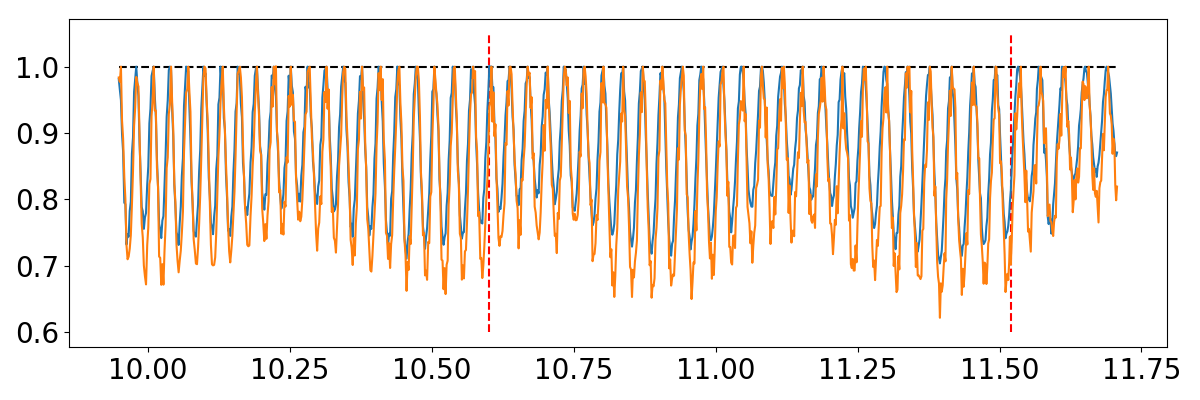

<IPython.core.display.Javascript object>


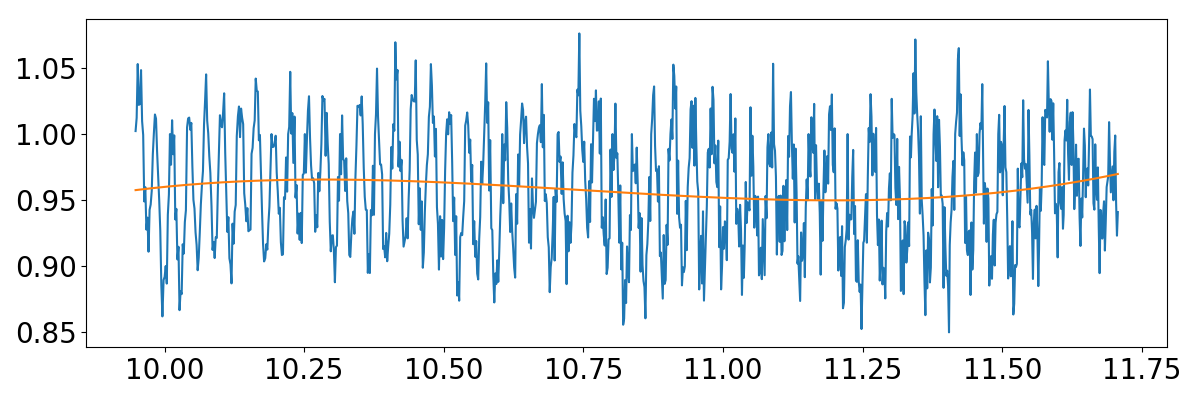

0.0199530081025


<IPython.core.display.Javascript object>


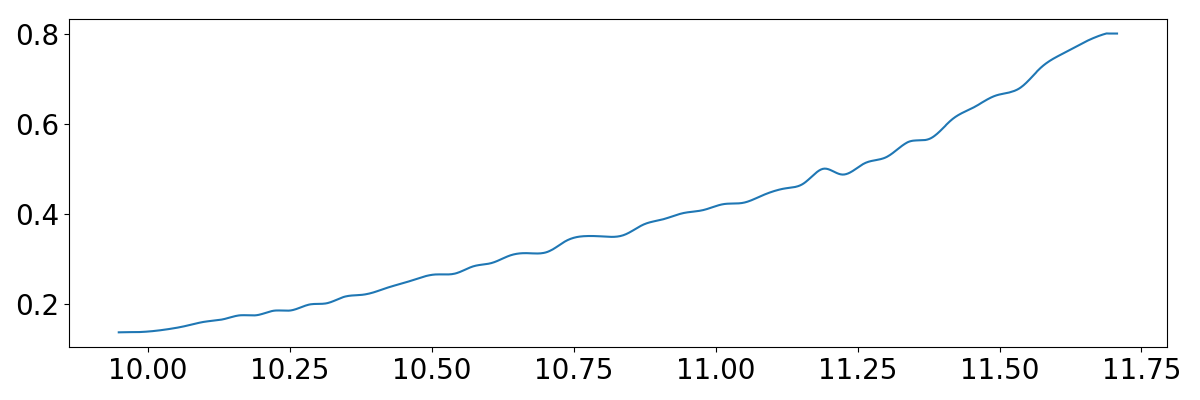

In [30]:
band = '2C'
lambdas = lambdaMap[band][ypos,xpos[band]][5:-2]
data = (img_H_1C/photom_img[band])[ypos,xpos[band]][5:-2]
data_noNaN_ext,peaks_ext,data_profile_ext = funcs.norm_fringe(data,thres=0,min_dist=14,k=3,ext=3)

data = (CV2_intcal_source_sci[band]/photom_img[band])[ypos,xpos[band]][5:-2]
data_noNaN_int,peaks_int,data_profile_int = funcs.norm_fringe(data,thres=0,min_dist=14,k=3,ext=3)

data_profile = data_profile_ext/data_profile_int

# Investigate region of interest
sel = (lambdas > 10.6) & (lambdas<11.52)
popt1     = np.polyfit(lambdas[~sel],data_profile[~sel],3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
# plt.plot(lambdas,data,alpha=0.1)
# plt.plot(lambdas,data_noNaN_ext/data_noNaN_int,alpha=0.4)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to 10.6$\mu$m>$\lambda$>11.52$\mu$m')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}  (computed worst case difference: 10%)'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(lambdas,data_noNaN_ext/data_profile_ext)
plt.plot(lambdas,data_noNaN_int/data_profile_int)
plt.hlines(1,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.vlines([10.6,11.52],0.6,1.05,'r',linestyle='dashed')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(lambdas,(data_noNaN_int/data_profile_int)/(data_noNaN_ext/data_profile_ext))

popt1     = np.polyfit(lambdas,(data_noNaN_int/data_profile_int)/(data_noNaN_ext/data_profile_ext),3)
poly1     = np.poly1d(popt1)

popt2     = np.polyfit(lambdas,(data_noNaN_int/data_profile_int)/(data_noNaN_ext/data_profile_ext),1)
poly2     = np.poly1d(popt2)

# plt.plot(lambdas,poly2(lambdas))
plt.plot(lambdas,poly1(lambdas))
# plt.hlines((poly1(lambdas).min()+poly1(lambdas).max())/2.,lambdas.min(),lambdas.max(),'r',linestyle='dashed')
plt.tight_layout()

print poly1(lambdas).max()-poly1(lambdas).min()

plt.figure(figsize=(12,4))
plt.plot(lambdas,data_profile_ext/data_profile_int )
# plt.plot(lambdas,data_noNaN_int/data_profile_int)
# plt.hlines(1,lambdas.min(),lambdas.max(),linestyle='dashed')
# plt.vlines([10.6,11.52],0.6,1.05,'r',linestyle='dashed')
plt.tight_layout()

## Check some other bands for potential systematics

<IPython.core.display.Javascript object>


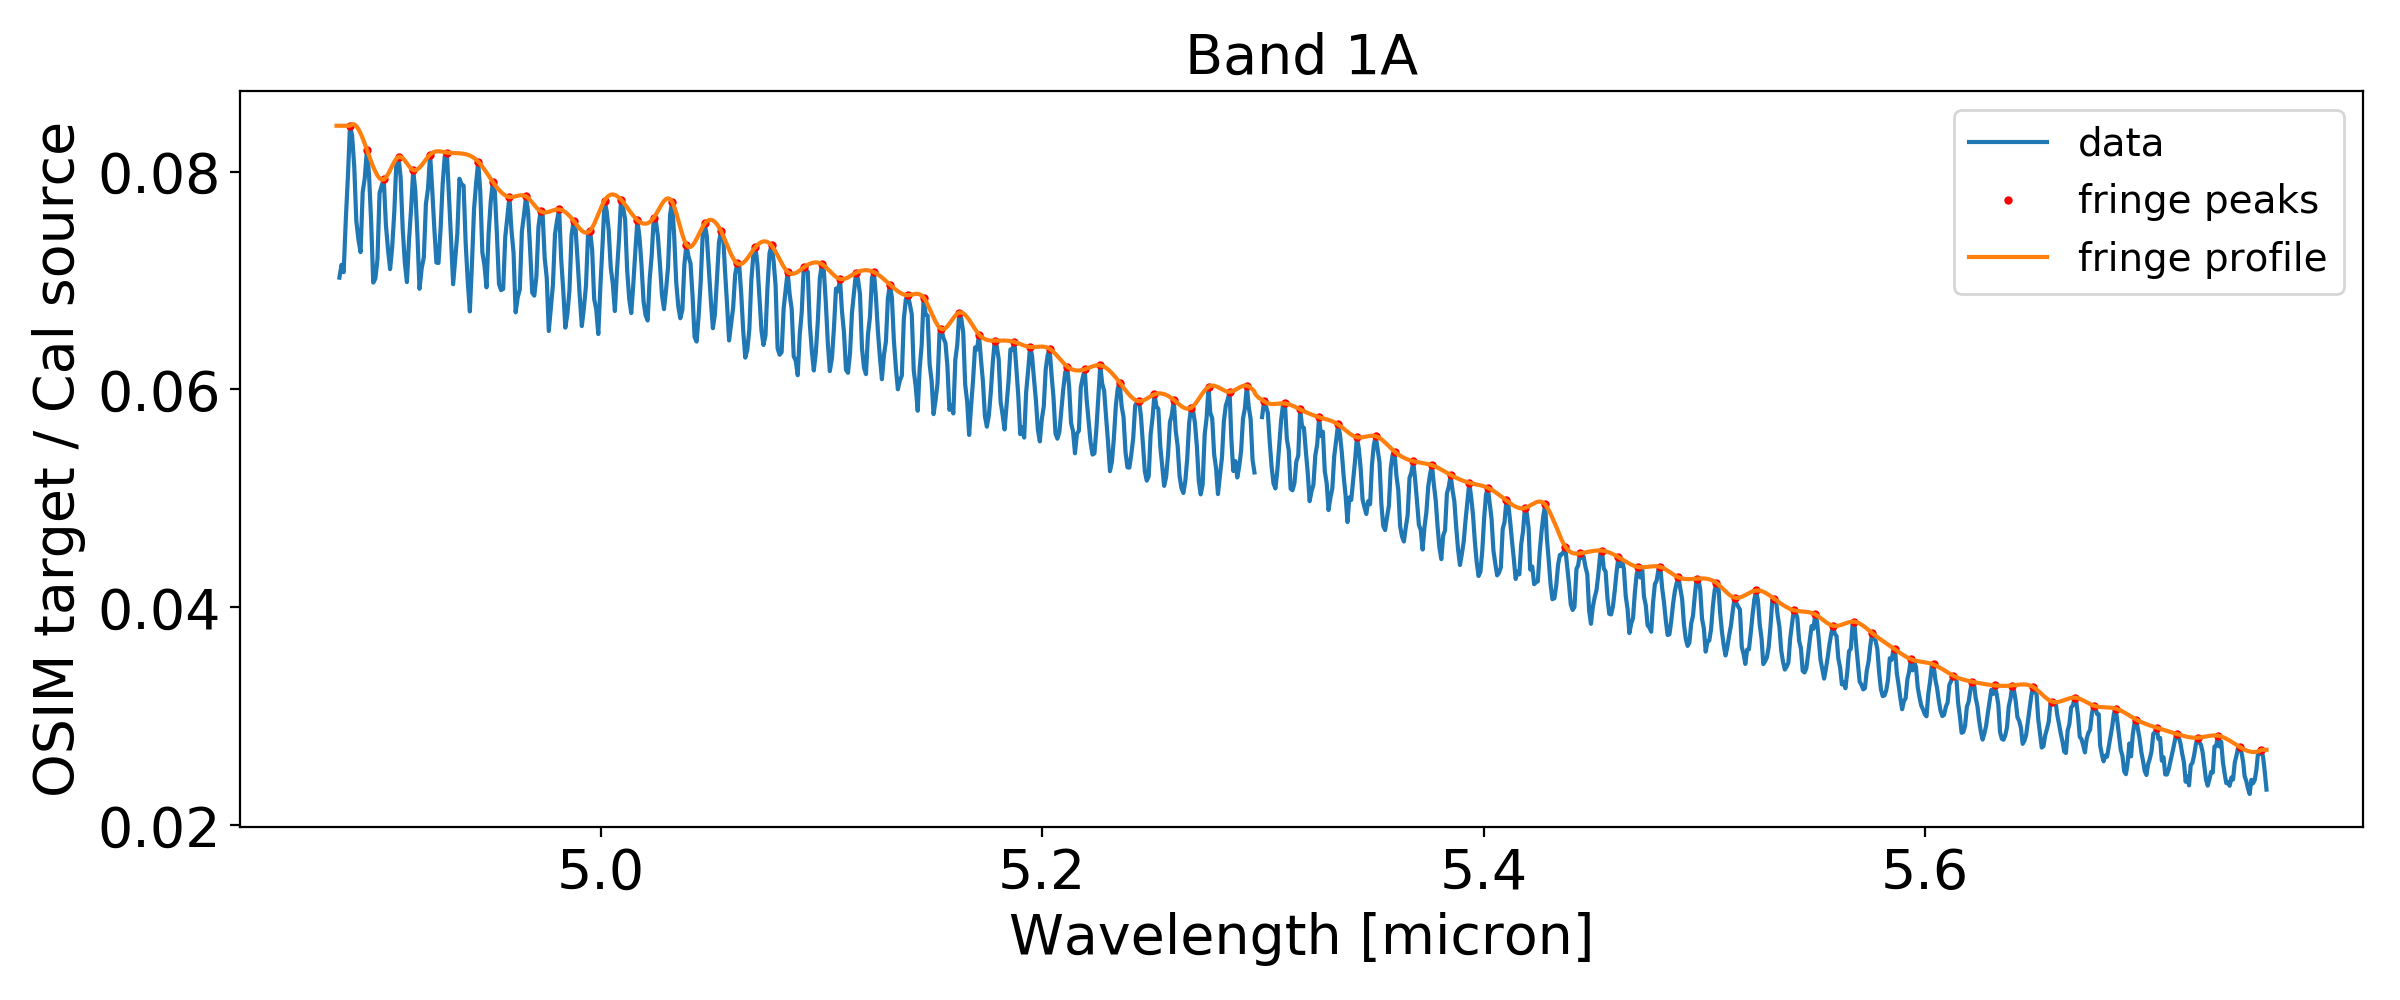

<IPython.core.display.Javascript object>


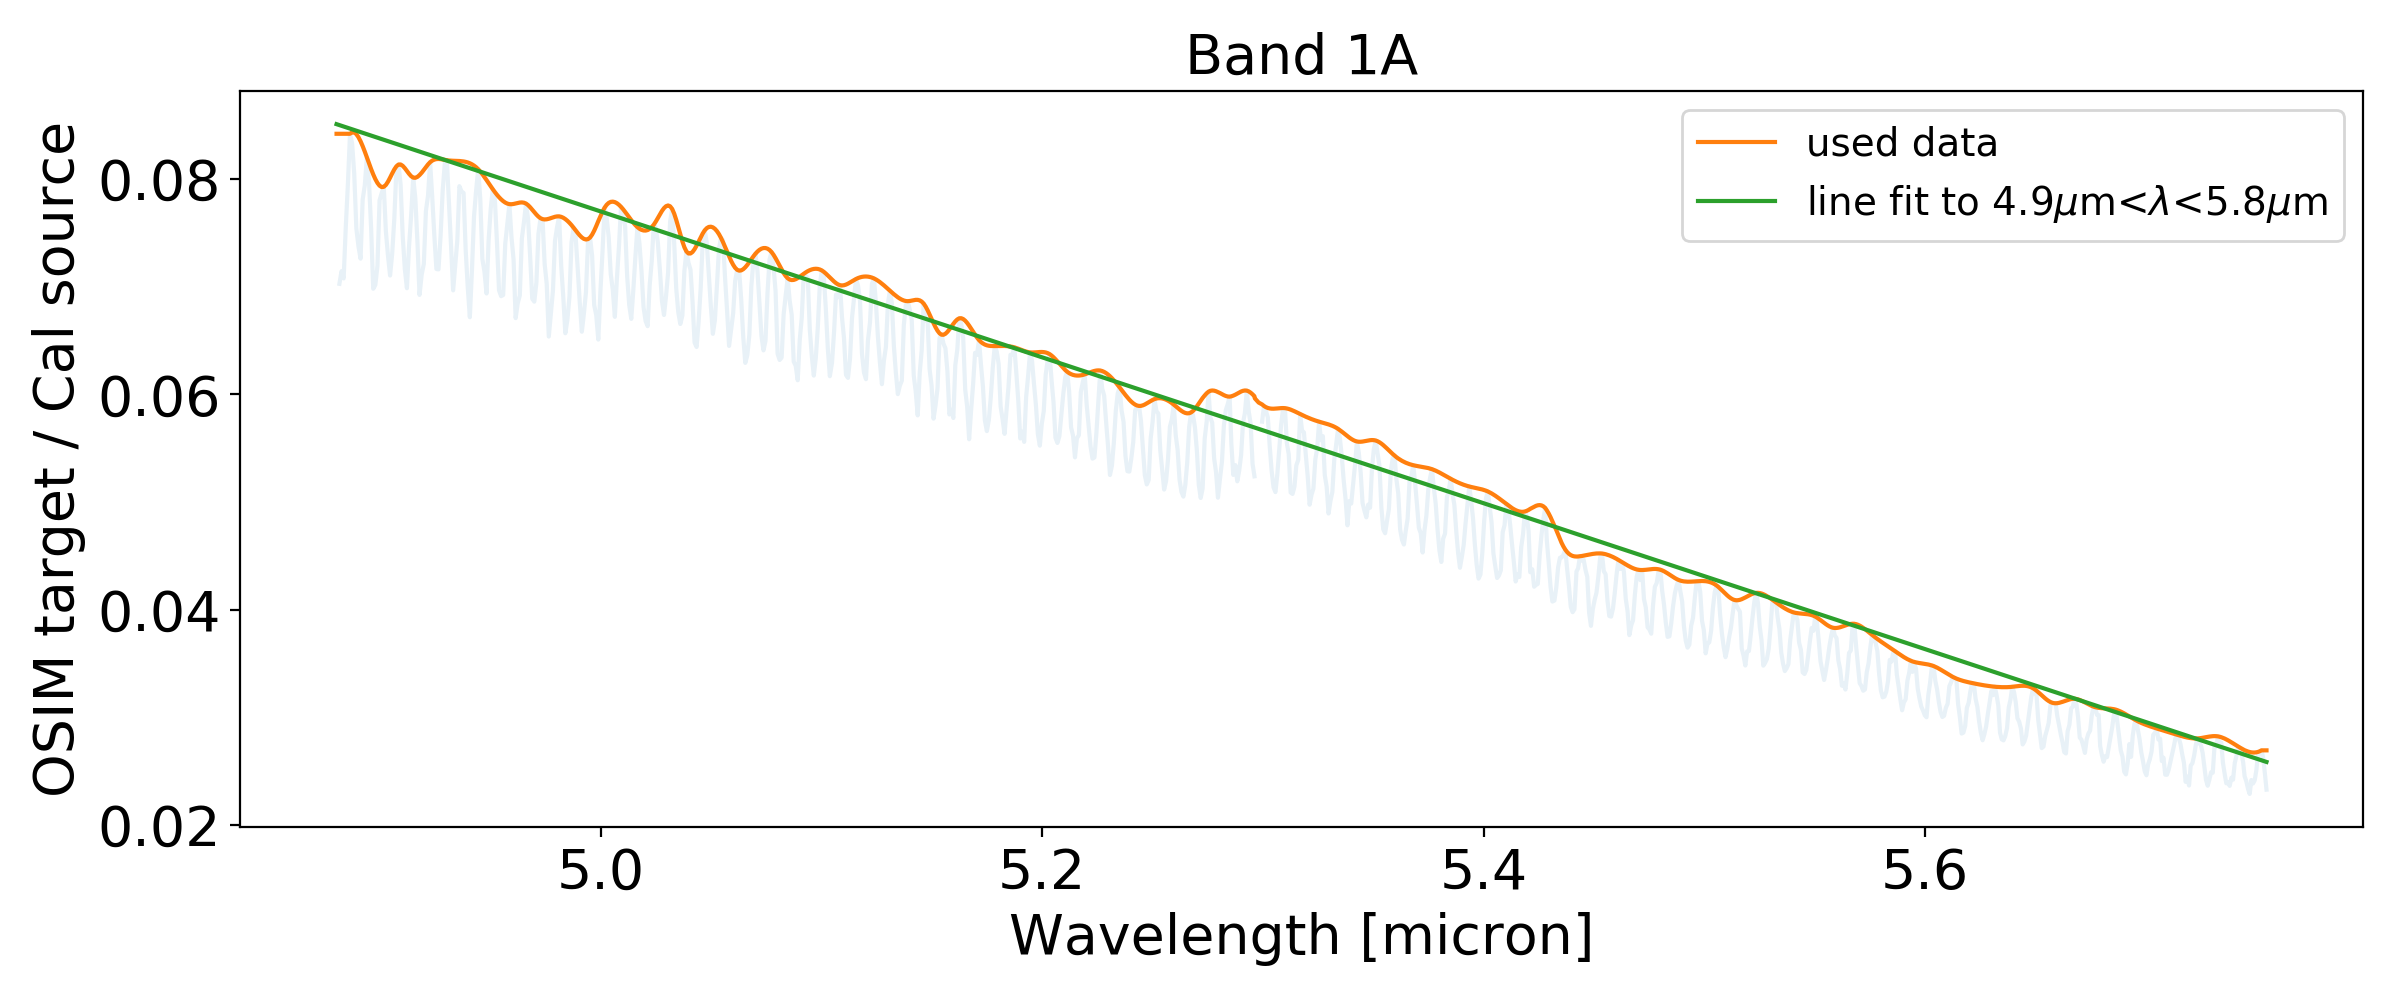

<IPython.core.display.Javascript object>


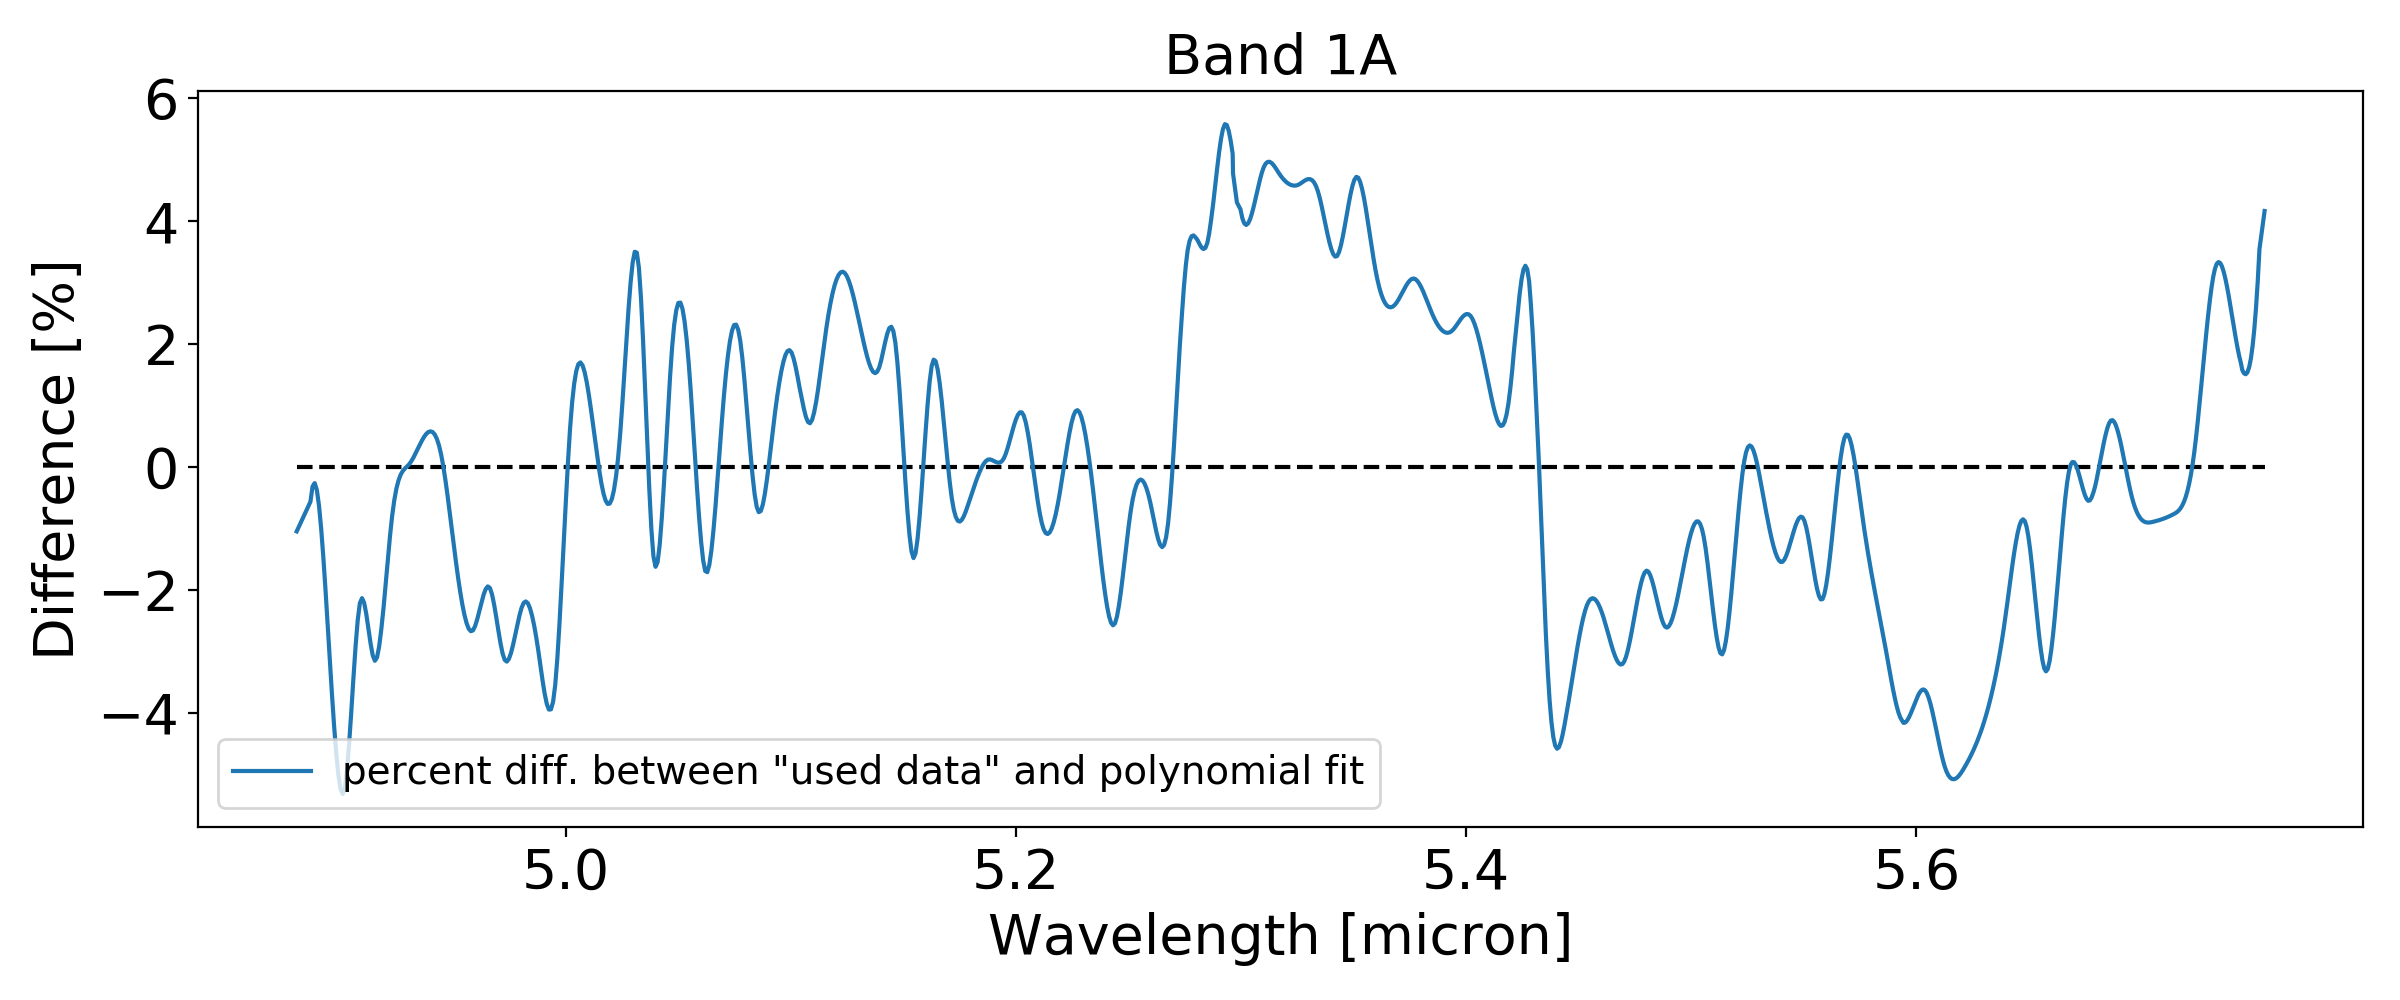

In [8]:
# Examine the OSIM sky flat data in band 1A (wavelength range 4.83-5.82 micron)
band = '1A'
lambdas = lambdaMap[band][ypos,xpos[band]][:-2]
data = ((img_H_1A-img_BKG_1A)/CV2_intcal_source_sci[band])[ypos,xpos[band]][:-2]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=6,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

# Investigate region of interest
popt1     = np.polyfit(lambdas,data_profile,1)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'line fit to {}$\mu$m<$\lambda$<{}$\mu$m'.format(round(lambdas.min(),1),round(lambdas.max(),1) ))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


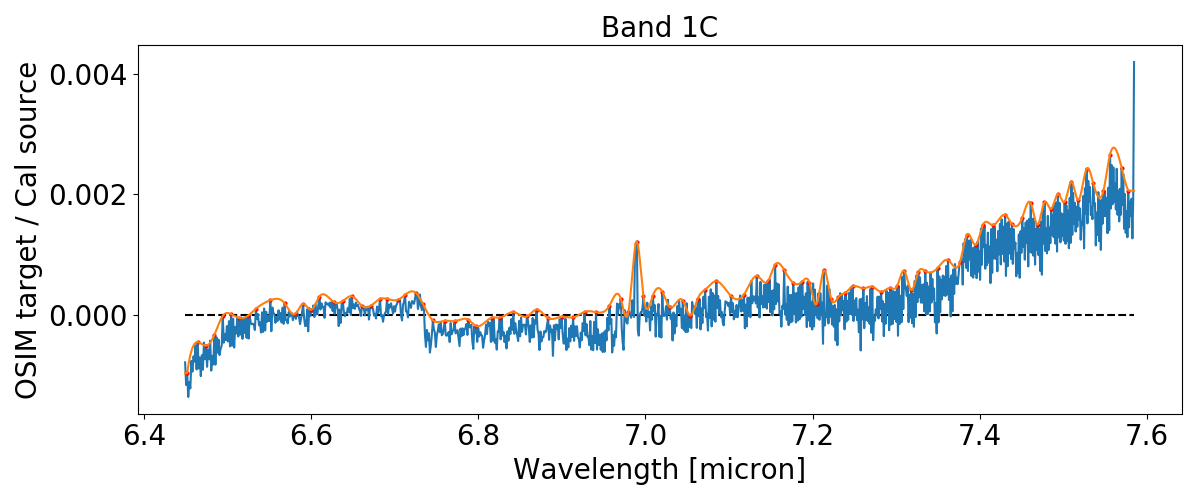

<IPython.core.display.Javascript object>


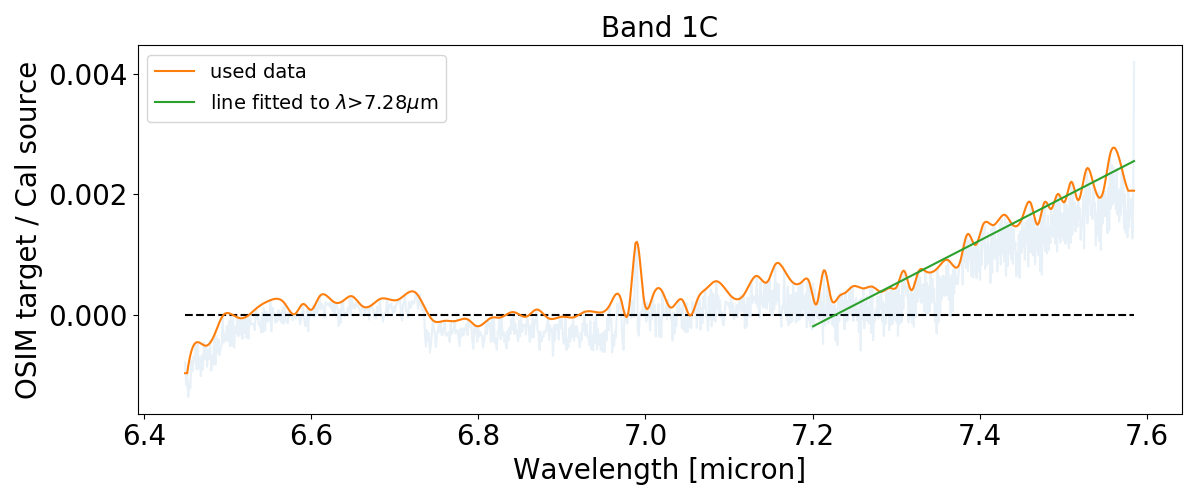

<IPython.core.display.Javascript object>


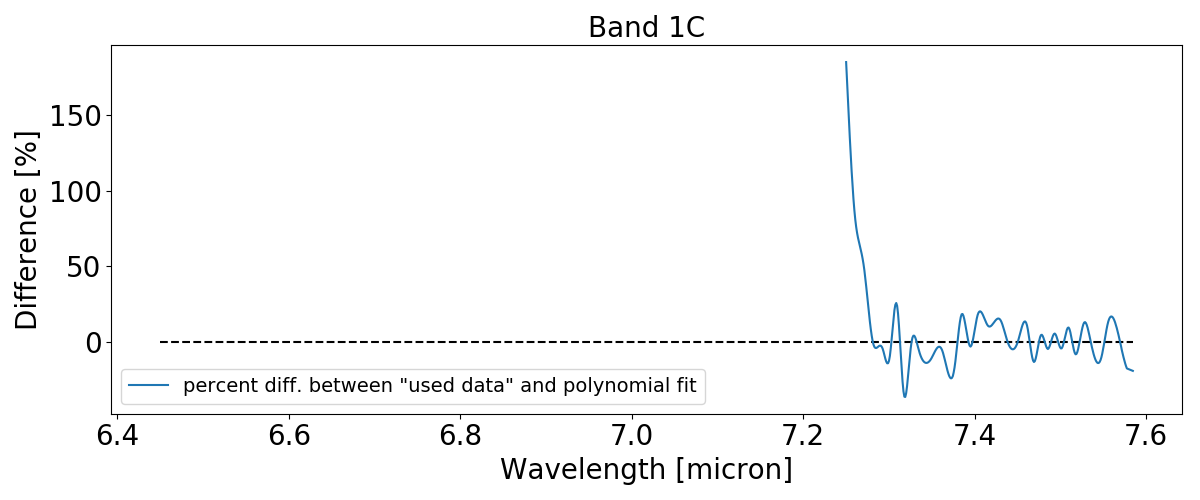

In [31]:
# Examine the OSIM sky flat data in band 1C (wavelength range 6.46,7.76 micron)
band = '1C'
lambdas = lambdaMap[band][ypos,xpos[band]][5:-2]
data = (img_H_1C/CV2_intcal_source_sci[band])[ypos,xpos[band]][5:-2]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=6,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',markersize=2,label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
# plt.legend(loc='upper left')
plt.tight_layout()

# Investigate region of interest
sel = (lambdas>7.28)
popt1     = np.polyfit(lambdas[sel],data_profile[sel],1)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas[(lambdas>7.2)],poly1(lambdas)[(lambdas>7.2)],label=r'line fitted to $\lambda$>7.28$\mu$m')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas[(lambdas>7.25)],((data_profile-poly1(lambdas))/poly1(lambdas))[(lambdas>7.25)]*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


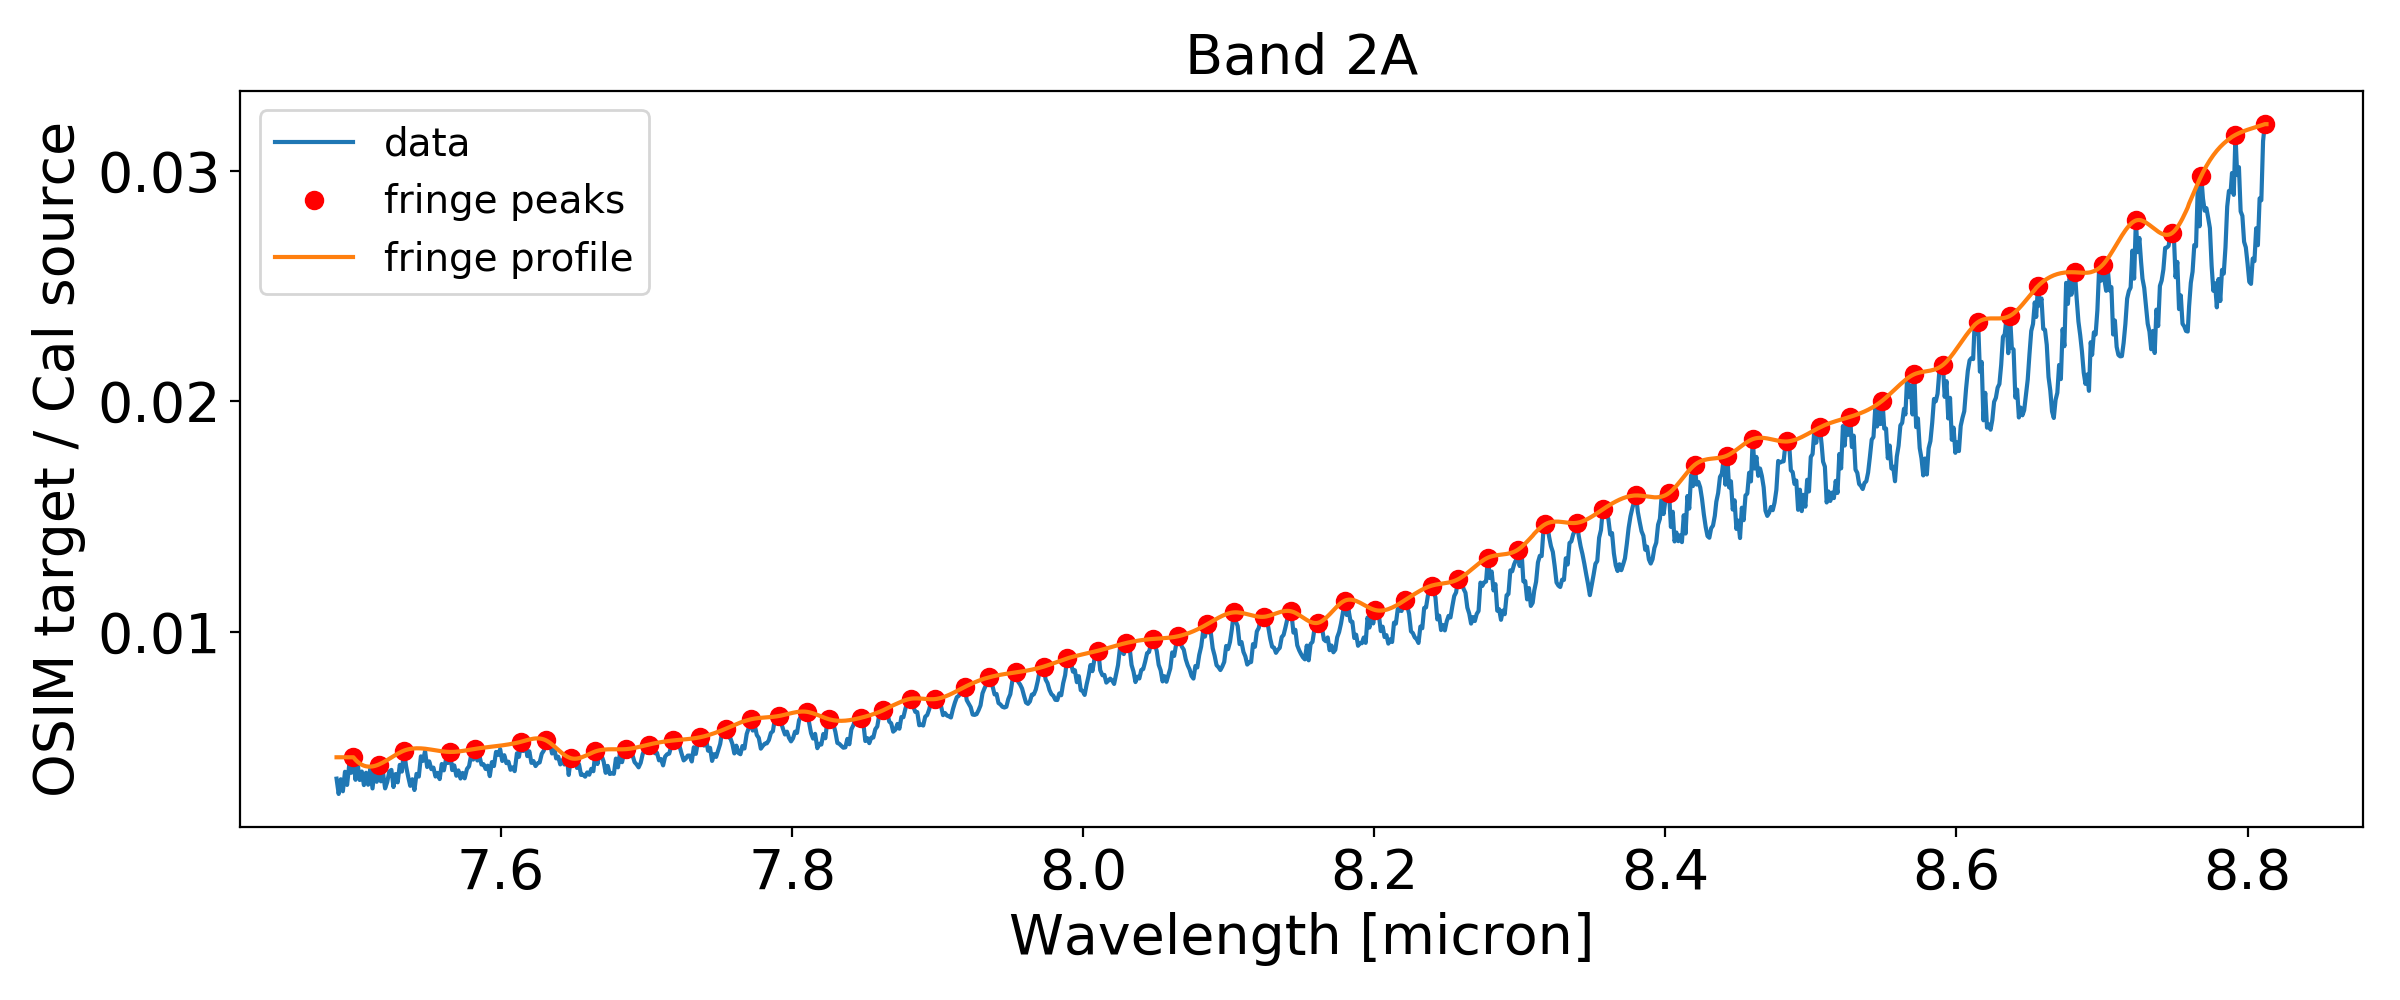

<IPython.core.display.Javascript object>


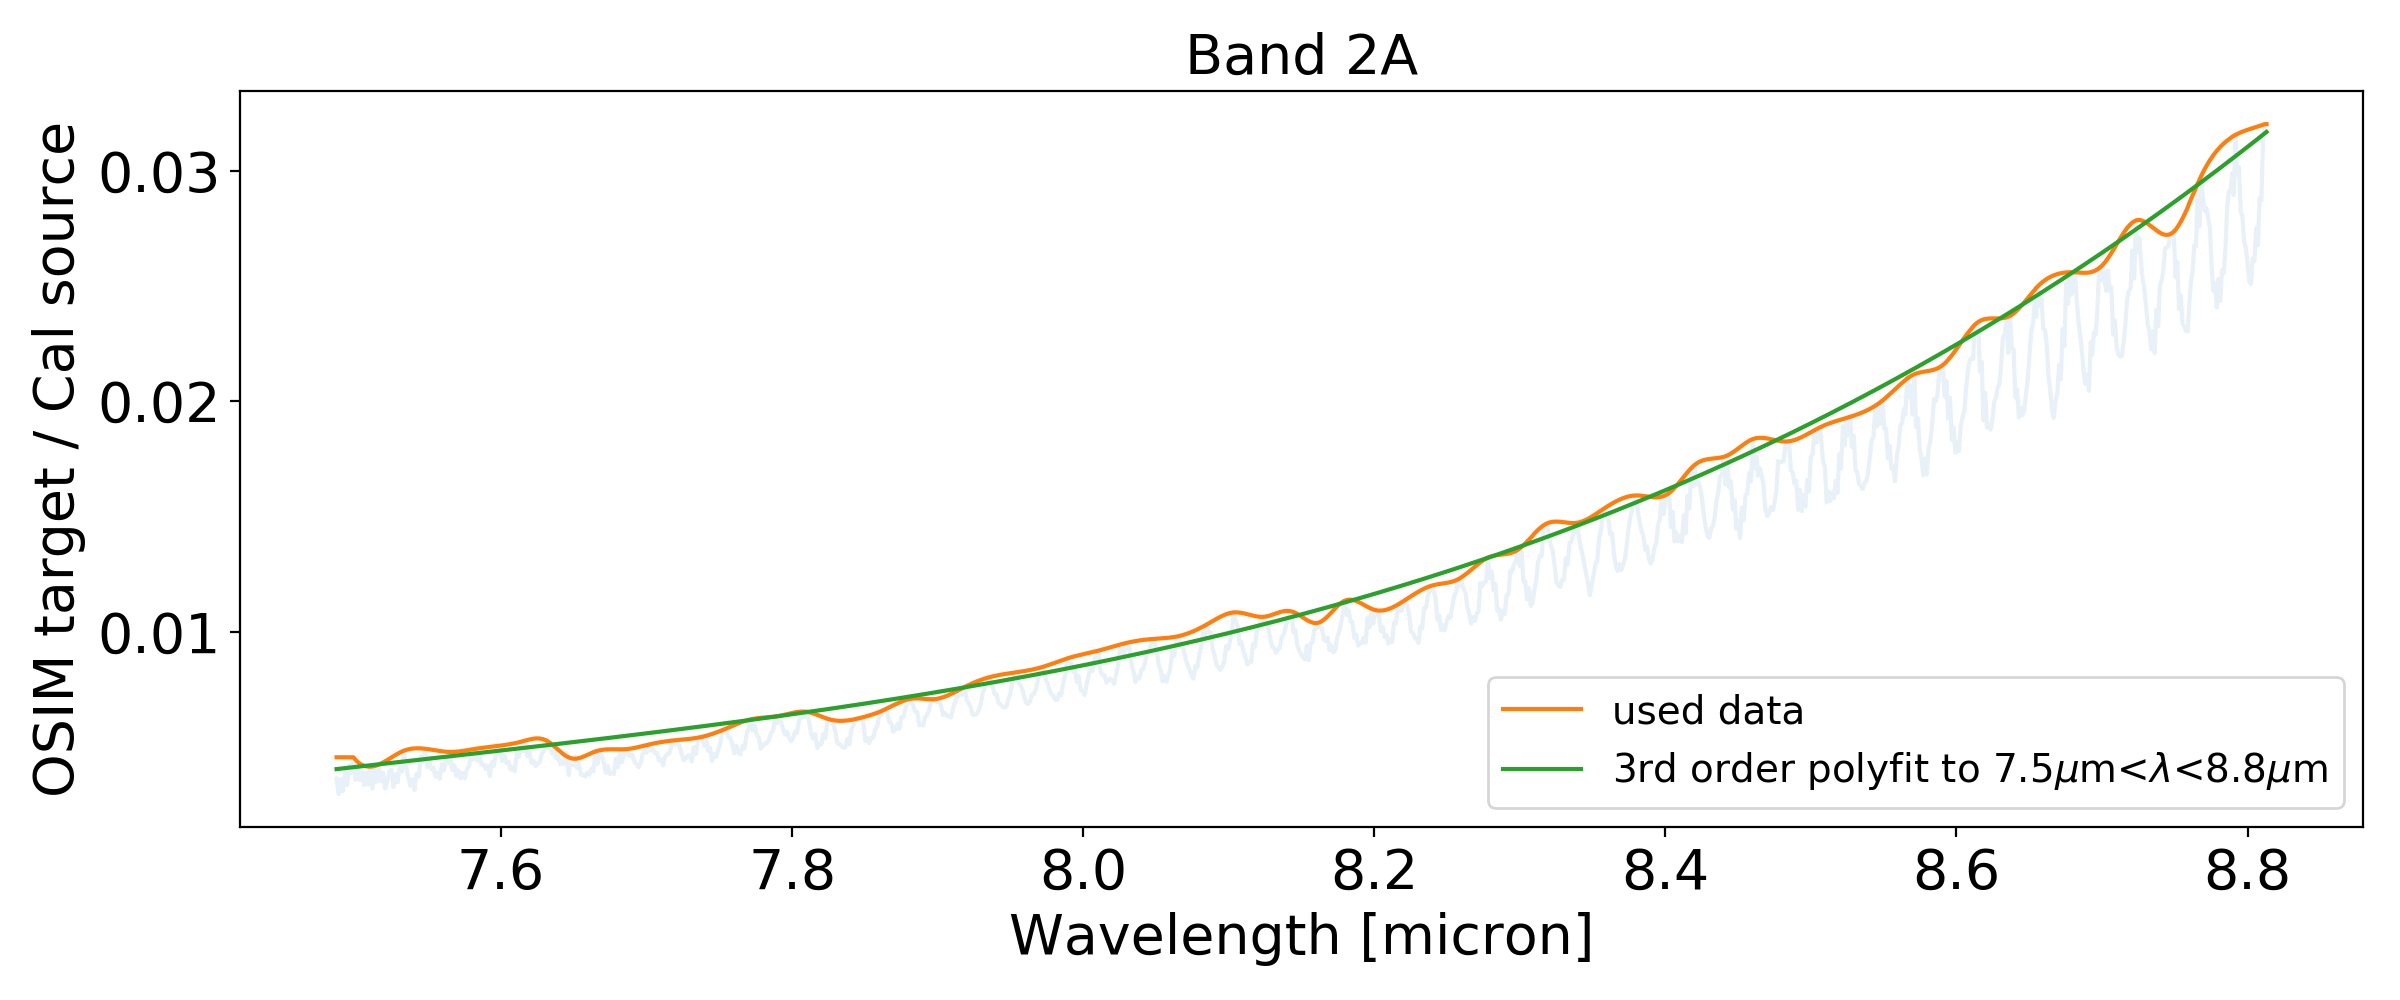

<IPython.core.display.Javascript object>


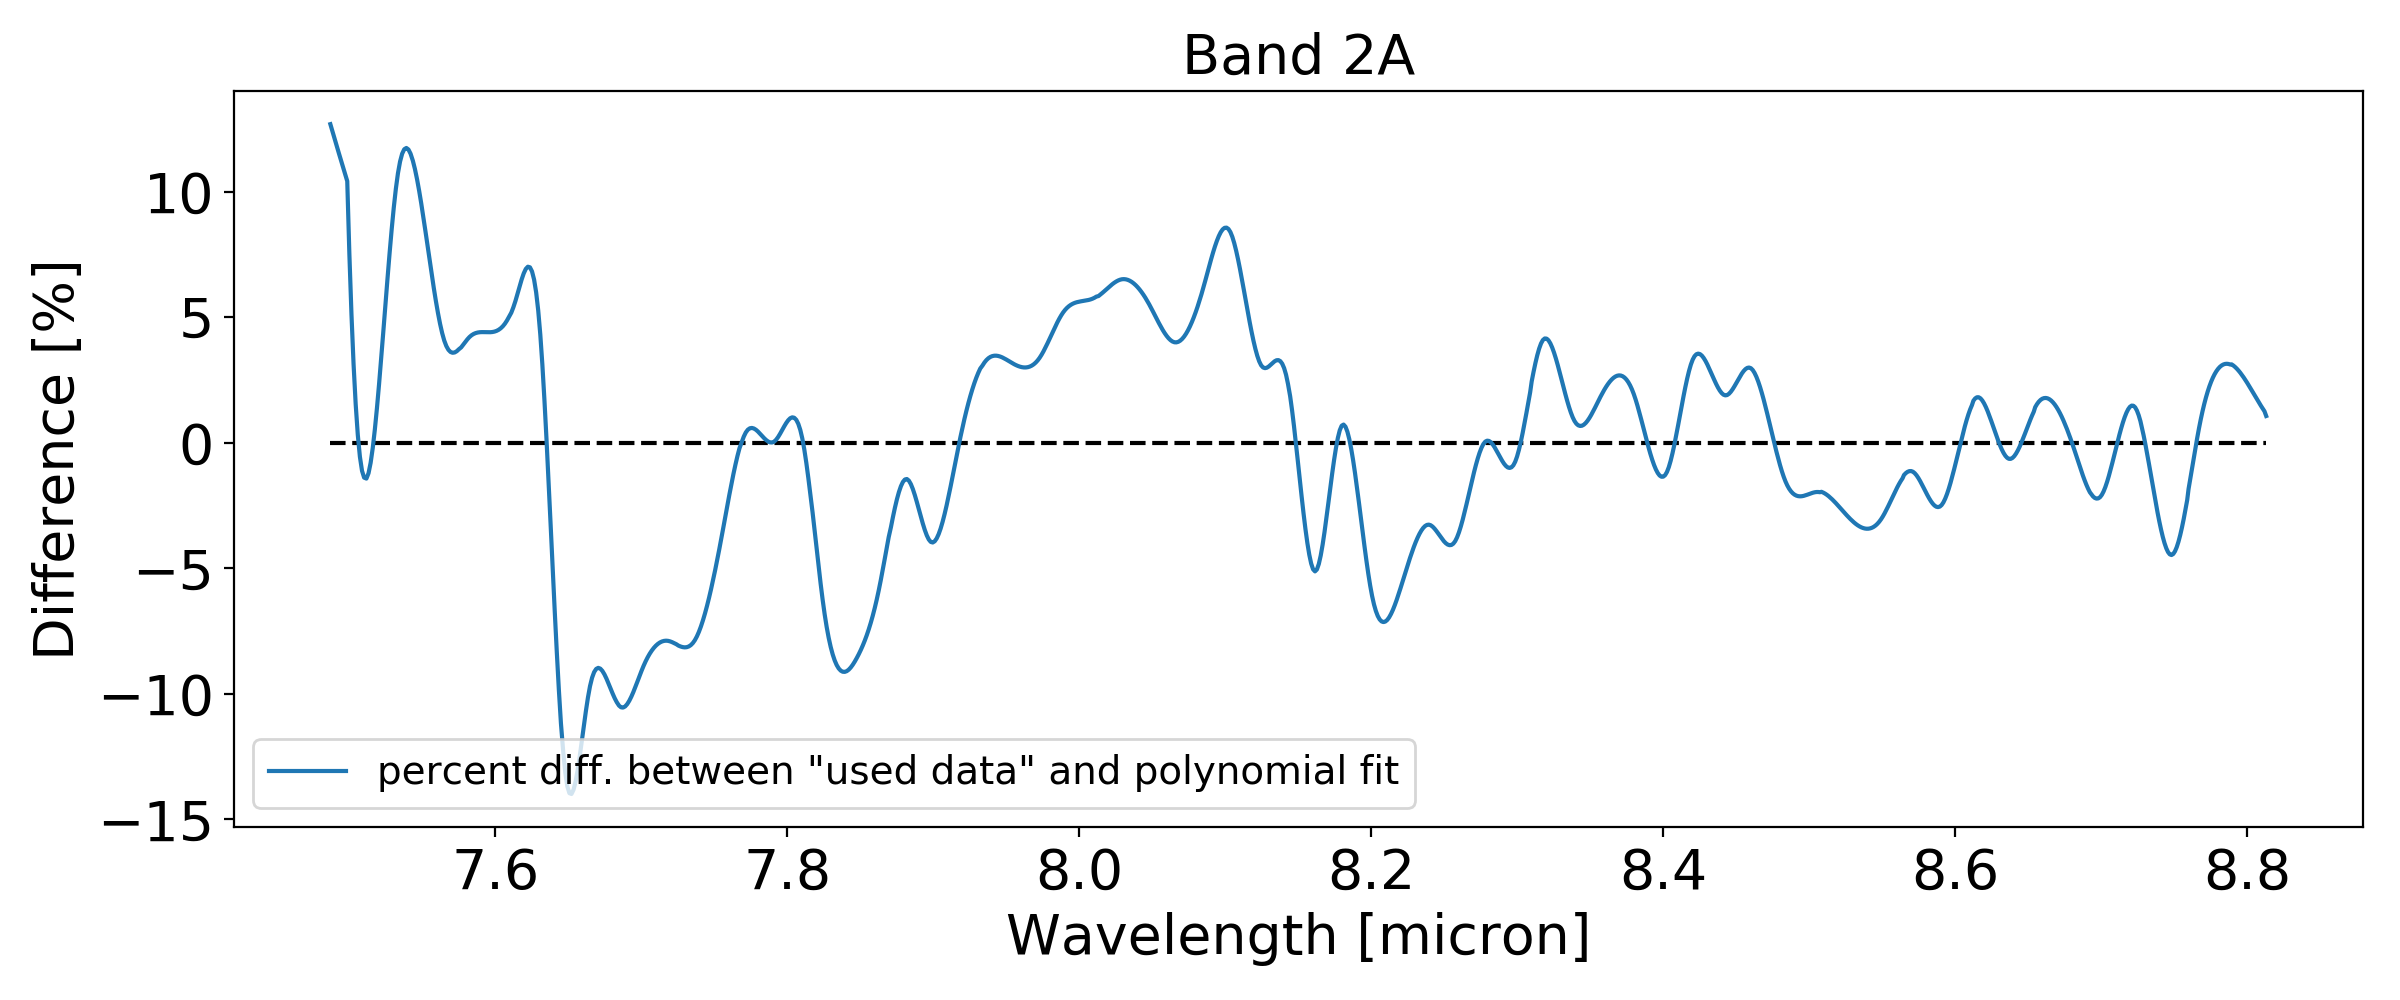

In [17]:
# Examine the OSIM sky flat data in band 2A (wavelength range 7.44-8.90 micron)
band = '2A'
lambdas = lambdaMap[band][ypos,xpos[band]][5:-3]
data = (img_H_1A/CV2_intcal_source_sci[band])[ypos,xpos[band]][5:-3]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=10,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# Investigate region of interest
popt1     = np.polyfit(lambdas,data_profile,3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to {}$\mu$m<$\lambda$<{}$\mu$m'.format(round(lambdas.min(),1),round(lambdas.max(),1)))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


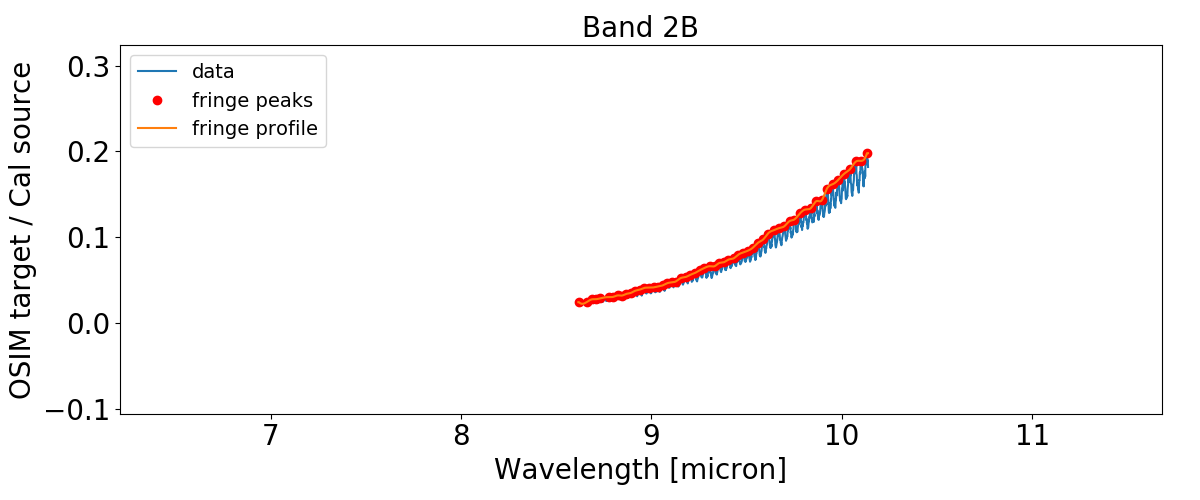

<IPython.core.display.Javascript object>


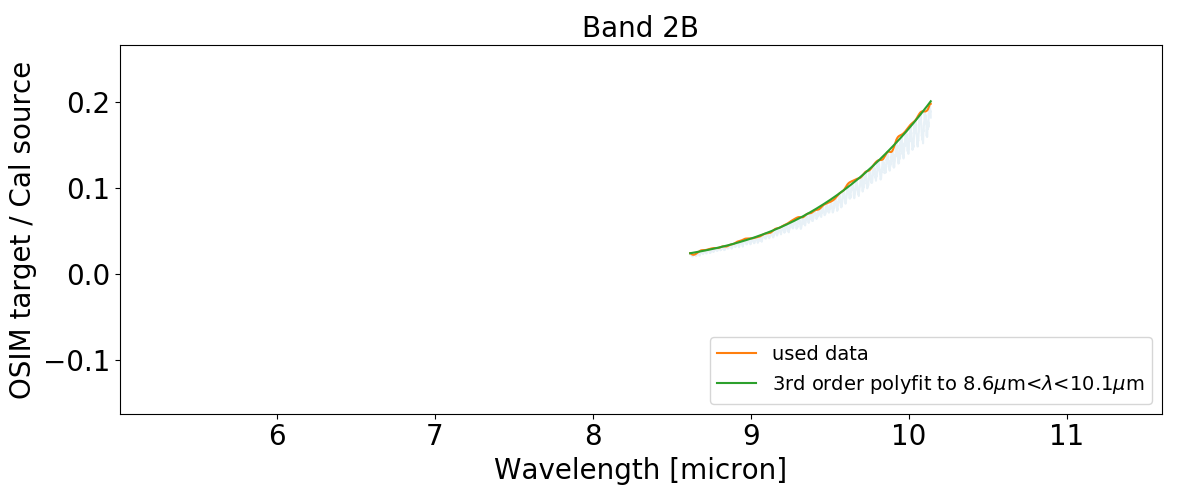

<IPython.core.display.Javascript object>


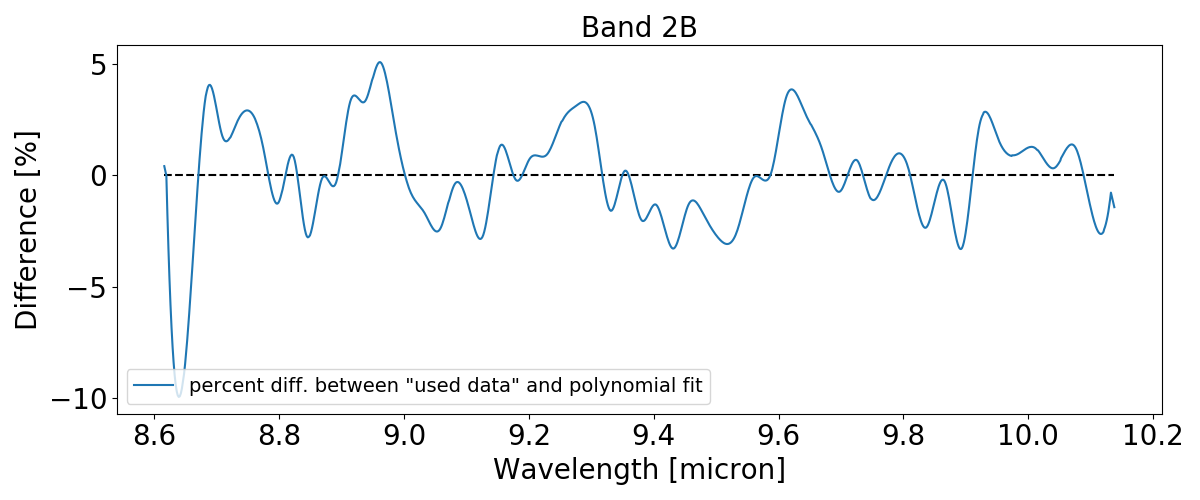

In [34]:
# Examine the OSIM sky flat data in band 2A (wavelength range 7.44-8.90 micron)
band = '2B'
lambdas = lambdaMap[band][ypos,xpos[band]][5:-3]
data = (img_H_1B/CV2_intcal_source_sci[band])[ypos,xpos[band]][5:-3]
data_noNaN,peaks,data_profile = funcs.norm_fringe(data,thres=0,min_dist=12,k=3,ext=3)

# plot starter analysis
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,label='data')
plt.plot(lambdas[peaks],data_noNaN[peaks],'ro',label='fringe peaks')
plt.plot(lambdas,data_profile,label='fringe profile')
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='upper left')
plt.tight_layout()

# Investigate region of interest
popt1     = np.polyfit(lambdas,data_profile,3)
poly1     = np.poly1d(popt1)

# plot resulting fit and residuals
plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,data,alpha=0.1)
plt.plot(lambdas,data_profile,label='used data')
plt.plot(lambdas,poly1(lambdas),label=r'3rd order polyfit to {}$\mu$m<$\lambda$<{}$\mu$m'.format(round(lambdas.min(),1),round(lambdas.max(),1)))
plt.xlabel('Wavelength [micron]')
plt.ylabel('OSIM target / Cal source')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Band {}'.format(band))
plt.plot(lambdas,((data_profile-poly1(lambdas))/poly1(lambdas))*100.,label='percent diff. between "used data" and polynomial fit')
plt.hlines(0,lambdas.min(),lambdas.max(),linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Difference [%]')
plt.legend(loc='lower left')
plt.tight_layout()